# Model-Based Collaborative Filtering (Matrix Factorization)

## Overview
Model-Based Collaborative Filtering uses matrix factorization to learn latent factors representing users and items. The rating matrix R is decomposed into two lower-rank matrices: U (user factors) and V (item factors), where R ≈ U·V^T. This captures hidden patterns in user preferences and item characteristics. Predictions are made via dot products, enabling fast inference and better generalization than memory-based methods.

## Notebook Structure
1. **Setup**: Import libraries, configure paths, and detect phase (training/tuning vs final evaluation)
2. **Core Functions**: Data loading, sparse matrix construction, SVD training (TruncatedSVD), prediction via matrix multiplication
3. **Evaluation**: RMSE, accuracy, and ranking metrics (Recall@K, NDCG@K, MAP@K) on validation and test sets
4. **Hyperparameter Tuning**: n_factors optimization on validation set with NDCG-primary selection (prefers smaller factors as tiebreaker)
5. **Pipeline Execution**: Automated training, tuning, and final evaluation with visualizations

## Process Flow
**Phase 1 - Training & Tuning:**
- Load 5-core train split → Build user-item sparse matrix (CSR format)
- Apply Truncated SVD to decompose R into U (user factors) and V (item factors)
- Test n_factors [10,20,30,50,75,100] on validation set → Select best using NDCG@10 (primary), prefer smallest (tiebreaker)
- Save tuned model with optimal n_factors

**Phase 2 - Final Evaluation:**
- Load tuned model → Evaluate on test set using best n_factors
- Generate metrics: RMSE, Accuracy, Recall@K, NDCG@K, MAP@K for K∈{10,20,50}
- Create visualizations: tuning curves, final results, validation vs test comparison

In [1]:
import os, sys, numpy as np, polars as pl, pickle, json, time
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..', '../utilities'))
if module_path not in sys.path:
    sys.path.append(module_path)

from logger import Logger
from configurations import Configurations
from visualization_helpers import (
    visualize_hyperparameter_tuning,
    visualize_final_results,
    visualize_val_test_comparison
)
from evaluation_metrics import compute_rmse_accuracy, recall_at_k, ndcg_at_k, map_at_k

logger = Logger(process_name="model_based", log_file=Configurations.LOG_PATH)
PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
MODELS_DIR = Path(Configurations.MODELS_PATH)
CATEGORY = Configurations.CATEGORIES

has_tuning = Configurations.has_tuning_results_model(CATEGORY[0])
FACTORS_VALUES = Configurations.FACTORS_VALUES
PHASE = 'final' if has_tuning else 'train_tune'

logger.log_info("="*70)
logger.log_info(f"PHASE: {'FINAL EVALUATION' if has_tuning else 'TRAINING + TUNING'} (MODEL-BASED)")
logger.log_info(f"Categories: {CATEGORY} | Sample: {Configurations.DEV_SAMPLE_SIZE}")
if not has_tuning:
    logger.log_info(f"n_factors: {FACTORS_VALUES}")
logger.log_info("="*70 + "\n")

N_RECS = 10
MEAN_CENTER = True
MAX_USERS = None
MAX_ITEMS = None
N_FACTORS = 50

2025-11-03 01:27:40,171 - INFO - ======================================================================
2025-11-03 01:27:40,172 - INFO - PHASE: TRAINING + TUNING (MODEL-BASED)
2025-11-03 01:27:40,172 - INFO - Categories: ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors'] | Sample: big
2025-11-03 01:27:40,172 - INFO - n_factors: [10, 20, 30, 50, 75]
2025-11-03 01:27:40,172 - INFO - ======================================================================



In [2]:
def _candidate_files(category: str, split: str = "train"):
    dev_sample = Configurations.DEV_SAMPLE_SIZE
    if dev_sample != 'full':
        for size_name in Configurations.SAMPLE_SIZES.keys():
            if size_name == dev_sample:
                return PROCESSED_DIR / f"{category.replace('/', '-')}.5core.{split}.{size_name}.parquet"
    return PROCESSED_DIR / f"{category.replace('/', '-')}.5core.{split}.parquet"

def load_5core_data(category: str, split: str = "train") -> pl.DataFrame:
    p = _candidate_files(category, split)
    df = pl.read_parquet(p, low_memory=False)
    df = df.with_columns([
        pl.when(pl.col("rating").cast(pl.Float32) < 1.0).then(1.0)
            .when(pl.col("rating").cast(pl.Float32) > 5.0).then(5.0)
            .otherwise(pl.col("rating").cast(pl.Float32)).alias("rating")
    ])
    logger.log_info(f"[{split.upper()}] shape={df.shape} | users={df['user_id'].n_unique()} | items={df['parent_asin'].n_unique()}")
    return df

In [3]:
def build_matrix_model(df_train: pl.DataFrame, max_users: int | None = None, 
                      max_items: int | None = None, mean_center: bool = True):
    df = df_train.drop_nulls(subset=['user_id', 'parent_asin', 'rating'])
    
    if max_users:
        df = df.filter(pl.col('user_id').is_in(df['user_id'].unique().to_list()[:max_users]))
    if max_items:
        df = df.filter(pl.col('parent_asin').is_in(df['parent_asin'].unique().to_list()[:max_items]))
    
    user_rev = np.array(df['user_id'].unique().to_list(), dtype=object)
    item_rev = np.array(df['parent_asin'].unique().to_list(), dtype=object)
    user_idx = {uid: idx for idx, uid in enumerate(user_rev)}
    item_idx = {iid: idx for idx, iid in enumerate(item_rev)}
    
    u = np.array([user_idx[x] for x in df['user_id'].to_list()], dtype=np.int32)
    i = np.array([item_idx[x] for x in df['parent_asin'].to_list()], dtype=np.int32)
    v = np.array(df['rating'].to_list(), dtype=np.float32)
    
    R = csr_matrix((v, (u, i)), shape=(user_rev.size, item_rev.size), dtype=np.float32)
    global_mean = np.mean(v)
    logger.log_info(f"[Matrix] R{R.shape} nnz={R.nnz} | global_mean={global_mean:.4f}")
    if mean_center:
        R_centered = R.copy()
        R_centered.data -= global_mean
        logger.log_info(f"[Centered] Mean of centered data={np.mean(R_centered.data):.4f}")
        return R, R_centered, user_idx, item_idx, user_rev, item_rev, global_mean
    
    return R, R, user_idx, item_idx, user_rev, item_rev, global_mean

def train_svd_model(R_train, n_factors=50):
    n_users, n_items = R_train.shape
    max_factors = min(n_users, n_items) - 1
    original_factors = n_factors
    
    if n_factors >= max_factors:
        n_factors = max(1, max_factors)
        logger.log_warning(f"n_factors={original_factors} too large for {R_train.shape}, adjusted to {n_factors}")
    
    if n_factors < 1:
        raise ValueError(f"Matrix too small {R_train.shape}! Need larger dataset.")
    
    start_time = time.time()
    U, sigma, Vt = svds(R_train, k=n_factors)
    U, sigma, Vt = U[:, ::-1], sigma[::-1], Vt[::-1, :]
    train_time = time.time() - start_time
    V = Vt.T  # Shape: (n_items, n_factors)
    
    logger.log_info(f"SVD: {train_time:.2f}s | U{U.shape}, V{V.shape} | σ[{sigma.min():.4f},{sigma.max():.4f}]")
    return U, V, train_time

In [4]:
def save_model_artifacts(out_dir: Path, R, R_centered, U, V, user_rev, item_rev, user_idx, item_idx, global_mean):
    out_dir.mkdir(parents=True, exist_ok=True)
    save_npz(out_dir / "R.npz", R)
    save_npz(out_dir / "R_centered.npz", R_centered)  # Save centered too
    np.save(out_dir / "U.npy", U)
    np.save(out_dir / "V.npy", V)
    np.save(out_dir / "global_mean.npy", np.array([global_mean]))  # FIX: Save mean
    with open(out_dir / "user_rev.pkl", "wb") as f: pickle.dump(user_rev, f)
    with open(out_dir / "item_rev.pkl", "wb") as f: pickle.dump(item_rev, f)
    (out_dir / "user_idx.json").write_text(json.dumps({str(k): int(v) for k, v in user_idx.items()}))
    (out_dir / "item_idx.json").write_text(json.dumps({str(k): int(v) for k, v in item_idx.items()}))

def load_model_artifacts(model_dir: str | Path):
    md = Path(model_dir)
    R = load_npz(md / "R.npz")
    U = np.load(md / "U.npy")
    V = np.load(md / "V.npy")
    with open(md / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
    with open(md / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
    user_idx = {k: int(v) for k, v in json.loads((md / "user_idx.json").read_text()).items()}
    item_idx = {k: int(v) for k, v in json.loads((md / "item_idx.json").read_text()).items()}
    global_mean_file = md / "global_mean.npy"
    if global_mean_file.exists():
        global_mean = np.load(global_mean_file)[0]
    else:
        global_mean = 4.24  # Default from dataset
        logger.log_warning(f"global_mean.npy not found, using default: {global_mean}")
    
    return dict(R=R, U=U, V=V, user_rev=user_rev, item_rev=item_rev, 
                user_idx=user_idx, item_idx=item_idx, global_mean=global_mean)

In [5]:
def predict_model_based(user_idx_val: int, U: np.ndarray, V: np.ndarray, 
                       R: csr_matrix, global_mean: float = 0.0, 
                       mean_centered: bool = True) -> np.ndarray:
    raw_pred = U[user_idx_val] @ V.T
    if mean_centered:
        predictions = raw_pred + global_mean
    else:
        predictions = raw_pred
    
    predictions = np.clip(predictions, 1.0, 5.0)
    
    return predictions

def recommend_model_based(user_id: str, n_recs: int, artifacts: dict) -> pl.DataFrame:
    U, V, R = artifacts['U'], artifacts['V'], artifacts['R']
    user_idx, item_rev = artifacts['user_idx'], artifacts['item_rev']
    
    if user_id not in user_idx:
        return pl.DataFrame(columns=["parent_asin", "score"])
    
    u = user_idx[user_id]
    global_mean = artifacts.get('global_mean', 4.24)
    scores = predict_model_based(u, U, V, R, global_mean, mean_centered=MEAN_CENTER)
    rated = set(R.getrow(u).indices.tolist())
    cand_mask = np.ones(len(scores), dtype=bool)
    if rated:
        cand_mask[list(rated)] = False
    
    cand_scores = scores[cand_mask]
    if cand_scores.size == 0:
        return pl.DataFrame(columns=["parent_asin", "score"])
    
    n_top = min(n_recs, cand_scores.size)
    cand_indices = np.nonzero(cand_mask)[0]
    top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
    picked = sorted([(int(cand_indices[p]), float(cand_scores[p])) for p in top_pos], key=lambda x: -x[1])
    
    return pl.DataFrame({"parent_asin": [item_rev[i] for i, _ in picked], "score": [s for _, s in picked]})

In [6]:
def evaluate_model_based(category: str, artifacts: dict, k_values: list = [10, 20, 50], 
                        split: str = "test", sample_users: int = 3000):
    df_eval = load_5core_data(category, split=split)
    train_users = list(artifacts['user_idx'].keys())
    df_eval = df_eval.filter(pl.col('user_id').is_in(train_users))
    
    if len(df_eval) == 0:
        return None
    
    eval_users = df_eval['user_id'].unique().to_list()
    if len(eval_users) > sample_users:
        np.random.seed(42)
        eval_users = np.random.choice(eval_users, sample_users, replace=False).tolist()
    
    metrics_acc = {'rmse': [], 'accuracy': [], **{f'{m}@{k}': [] for m in ['recall', 'ndcg', 'map'] for k in k_values}}
    U, V, R = artifacts['U'], artifacts['V'], artifacts['R']
    item_idx, item_rev = artifacts['item_idx'], artifacts['item_rev']
    global_mean = artifacts.get('global_mean', 4.24)
    
    for user_id in eval_users:
        if user_id not in artifacts['user_idx']:
            continue
        
        u = artifacts['user_idx'][user_id]
        user_eval = df_eval.filter(pl.col('user_id') == user_id)
        actual_items = set(user_eval['parent_asin'].to_list())
        known_items = {item for item in actual_items if item in item_idx}
        
        if not known_items:
            continue
        
        actual_ratings = {row['parent_asin']: row['rating'] for row in user_eval.iter_rows(named=True)}
        scores = predict_model_based(u, U, V, R, global_mean, mean_centered=MEAN_CENTER)
        
        predictions = np.full(R.shape[1], np.nan)
        actuals = np.full(R.shape[1], np.nan)
        for asin in known_items:
            idx = item_idx[asin]
            predictions[idx] = scores[idx]
            actuals[idx] = actual_ratings[asin]
        
        rmse, acc = compute_rmse_accuracy(predictions, actuals)
        if not np.isnan(rmse):
            metrics_acc['rmse'].append(rmse)
            metrics_acc['accuracy'].append(acc)
        
        rated = set(R.getrow(u).indices.tolist())
        cand_mask = np.ones(R.shape[1], dtype=bool)
        if rated:
            cand_mask[list(rated)] = False
        
        cand_scores = scores[cand_mask]
        if cand_scores.size == 0:
            continue
        
        cand_indices = np.nonzero(cand_mask)[0]
        max_k = max(k_values)
        n_top = min(max_k, cand_scores.size)
        top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
        sorted_idx = top_pos[np.argsort(-cand_scores[top_pos])]
        recommended = [item_rev[cand_indices[i]] for i in sorted_idx]
        
        for k in k_values:
            metrics_acc[f'recall@{k}'].append(recall_at_k(recommended, known_items, k))
            metrics_acc[f'ndcg@{k}'].append(ndcg_at_k(recommended, known_items, k))
            metrics_acc[f'map@{k}'].append(map_at_k(recommended, known_items, k))
    
    results = {'category': category, 'split': split, 'n_users': len(eval_users),
               'rmse': np.mean(metrics_acc['rmse']) if metrics_acc['rmse'] else np.nan,
               'accuracy': np.mean(metrics_acc['accuracy']) if metrics_acc['accuracy'] else np.nan}
    
    for k in k_values:
        for metric in ['recall', 'ndcg', 'map']:
            key = f'{metric}@{k}'
            results[key] = np.mean(metrics_acc[key]) if metrics_acc[key] else 0.0
    
    logger.log_info(f"[Eval] RMSE={results['rmse']:.4f}, NDCG@10={results['ndcg@10']:.4f}")
    return results

In [7]:
def select_best_factors(df_results: pl.DataFrame):
    best_factors_ndcg = df_results['n_factors'][df_results['NDCG@10'].arg_max()]
    best_ndcg = df_results['NDCG@10'].max()
    threshold = best_ndcg * 0.98
    similar_rows = df_results.filter(pl.col('NDCG@10') >= threshold)
    similar_factors = similar_rows['n_factors'].to_list()
    
    if len(similar_factors) > 1:
        best_factors = min(similar_factors)
        logger.log_info(f"Selected n_factors={best_factors} (smallest among similar NDCG)")
    else:
        best_factors = best_factors_ndcg
        logger.log_info(f"Selected n_factors={best_factors} (highest NDCG@10)")
    
    return best_factors

In [8]:
def _train_single_category(cat, model_dir, FACTORS_VALUES, n_eval_tune):
    if not (model_dir / "R.npz").exists():
        logger.log_info("[Train] Building matrix and initial model...")
        df_train = load_5core_data(cat, split="train")
        R, R_centered, user_idx, item_idx, user_rev, item_rev, global_mean = build_matrix_model(
            df_train, max_users=MAX_USERS, max_items=MAX_ITEMS, mean_center=MEAN_CENTER)
        
        max_factors = min(R.shape) - 1
        initial_factors = min(50, max_factors)
        R_train = R_centered if MEAN_CENTER else R
        U, V, _ = train_svd_model(R_train, n_factors=initial_factors)
        save_model_artifacts(model_dir, R, R_centered, U, V, user_rev, item_rev, user_idx, item_idx, global_mean)
    
    if not Configurations.has_tuning_results_model(cat):
        logger.log_info("[Tune] Starting hyperparameter tuning...")
        artifacts = load_model_artifacts(model_dir)
        R = artifacts['R']
        max_factors = min(R.shape) - 1
        valid_factors = [f for f in FACTORS_VALUES if f <= max_factors]
        
        if not valid_factors:
            valid_factors = [max_factors]
        
        R_train = artifacts.get('R_centered', artifacts['R']) if MEAN_CENTER else artifacts['R']
        global_mean = artifacts.get('global_mean', 4.24)
        base_artifacts = {k: artifacts[k] for k in ['R', 'user_rev', 'item_rev', 'user_idx', 'item_idx', 'global_mean']}
        results = []
        
        for n_factors in valid_factors:
            U, V, train_time = train_svd_model(R_train, n_factors=n_factors)
            eval_artifacts = {**base_artifacts, 'U': U, 'V': V, 'n_factors': n_factors}
            metrics = evaluate_model_based(cat, eval_artifacts, k_values=[10, 20, 50], split="valid", sample_users=n_eval_tune)
            
            if metrics:
                results.append({'n_factors': n_factors, **{f'{m.upper()}@{kv}': metrics[f'{m}@{kv}']
                    for m in ['ndcg', 'recall', 'map'] for kv in [10, 20, 50]},
                    'RMSE': metrics['rmse'], 'Accuracy': metrics['accuracy'], 'Train_Time': train_time})
        
        if not results:
            best_factors = max_factors
            U, V, _ = train_svd_model(R, n_factors=max_factors)
        else:
            df_results = pl.DataFrame(results)
            df_results.write_csv(MODELS_DIR / 'model' / f'tuning_{cat}.csv')
            best_factors = select_best_factors(df_results)
            
            visualize_hyperparameter_tuning(df_results, category=cat, param_col='n_factors',
                param_name='n_factors (Latent Dimensions)', save_dir=MODELS_DIR / 'model', algo_name='Model-Based')
            
            U, V, _ = train_svd_model(R_train, n_factors=best_factors)
        
        save_model_artifacts(model_dir, R, R_train, U, V, artifacts['user_rev'], artifacts['item_rev'],
                           artifacts['user_idx'], artifacts['item_idx'], global_mean)
        Configurations.save_best_factors(cat, best_factors)
        return {'tuned_now': True, 'best_factors': best_factors}
    
    return {'tuned_now': False, 'best_factors': Configurations.load_best_factors(cat)}

2025-11-03 01:27:40,300 - INFO - PHASE 1: TRAINING + TUNING

2025-11-03 01:27:40,300 - INFO - 
Electronics
2025-11-03 01:27:40,301 - INFO - [Train] Building matrix and initial model...
2025-11-03 01:27:40,326 - INFO - [TRAIN] shape=(51914, 4) | users=32556 | items=28
2025-11-03 01:27:40,350 - INFO - [Matrix] R(32556, 28) nnz=51914 | global_mean=4.4985
2025-11-03 01:27:40,350 - INFO - [Centered] Mean of centered data=0.0000
2025-11-03 01:27:40,350 - WARNING - n_factors=27 too large for (32556, 28), adjusted to 27
2025-11-03 01:27:40,372 - INFO - SVD: 0.02s | U(32556, 27), V(28, 27) | σ[28.9388,72.4378]
2025-11-03 01:27:40,442 - INFO - [Tune] Starting hyperparameter tuning...
2025-11-03 01:27:40,470 - INFO - SVD: 0.01s | U(32556, 10), V(28, 10) | σ[193.1404,337.9590]
2025-11-03 01:27:40,472 - INFO - [VALID] shape=(456, 4) | users=456 | items=26
2025-11-03 01:27:40,625 - INFO - [Eval] RMSE=0.8171, NDCG@10=0.1708
2025-11-03 01:27:40,642 - INFO - SVD: 0.02s | U(32556, 20), V(28, 20) | σ[166

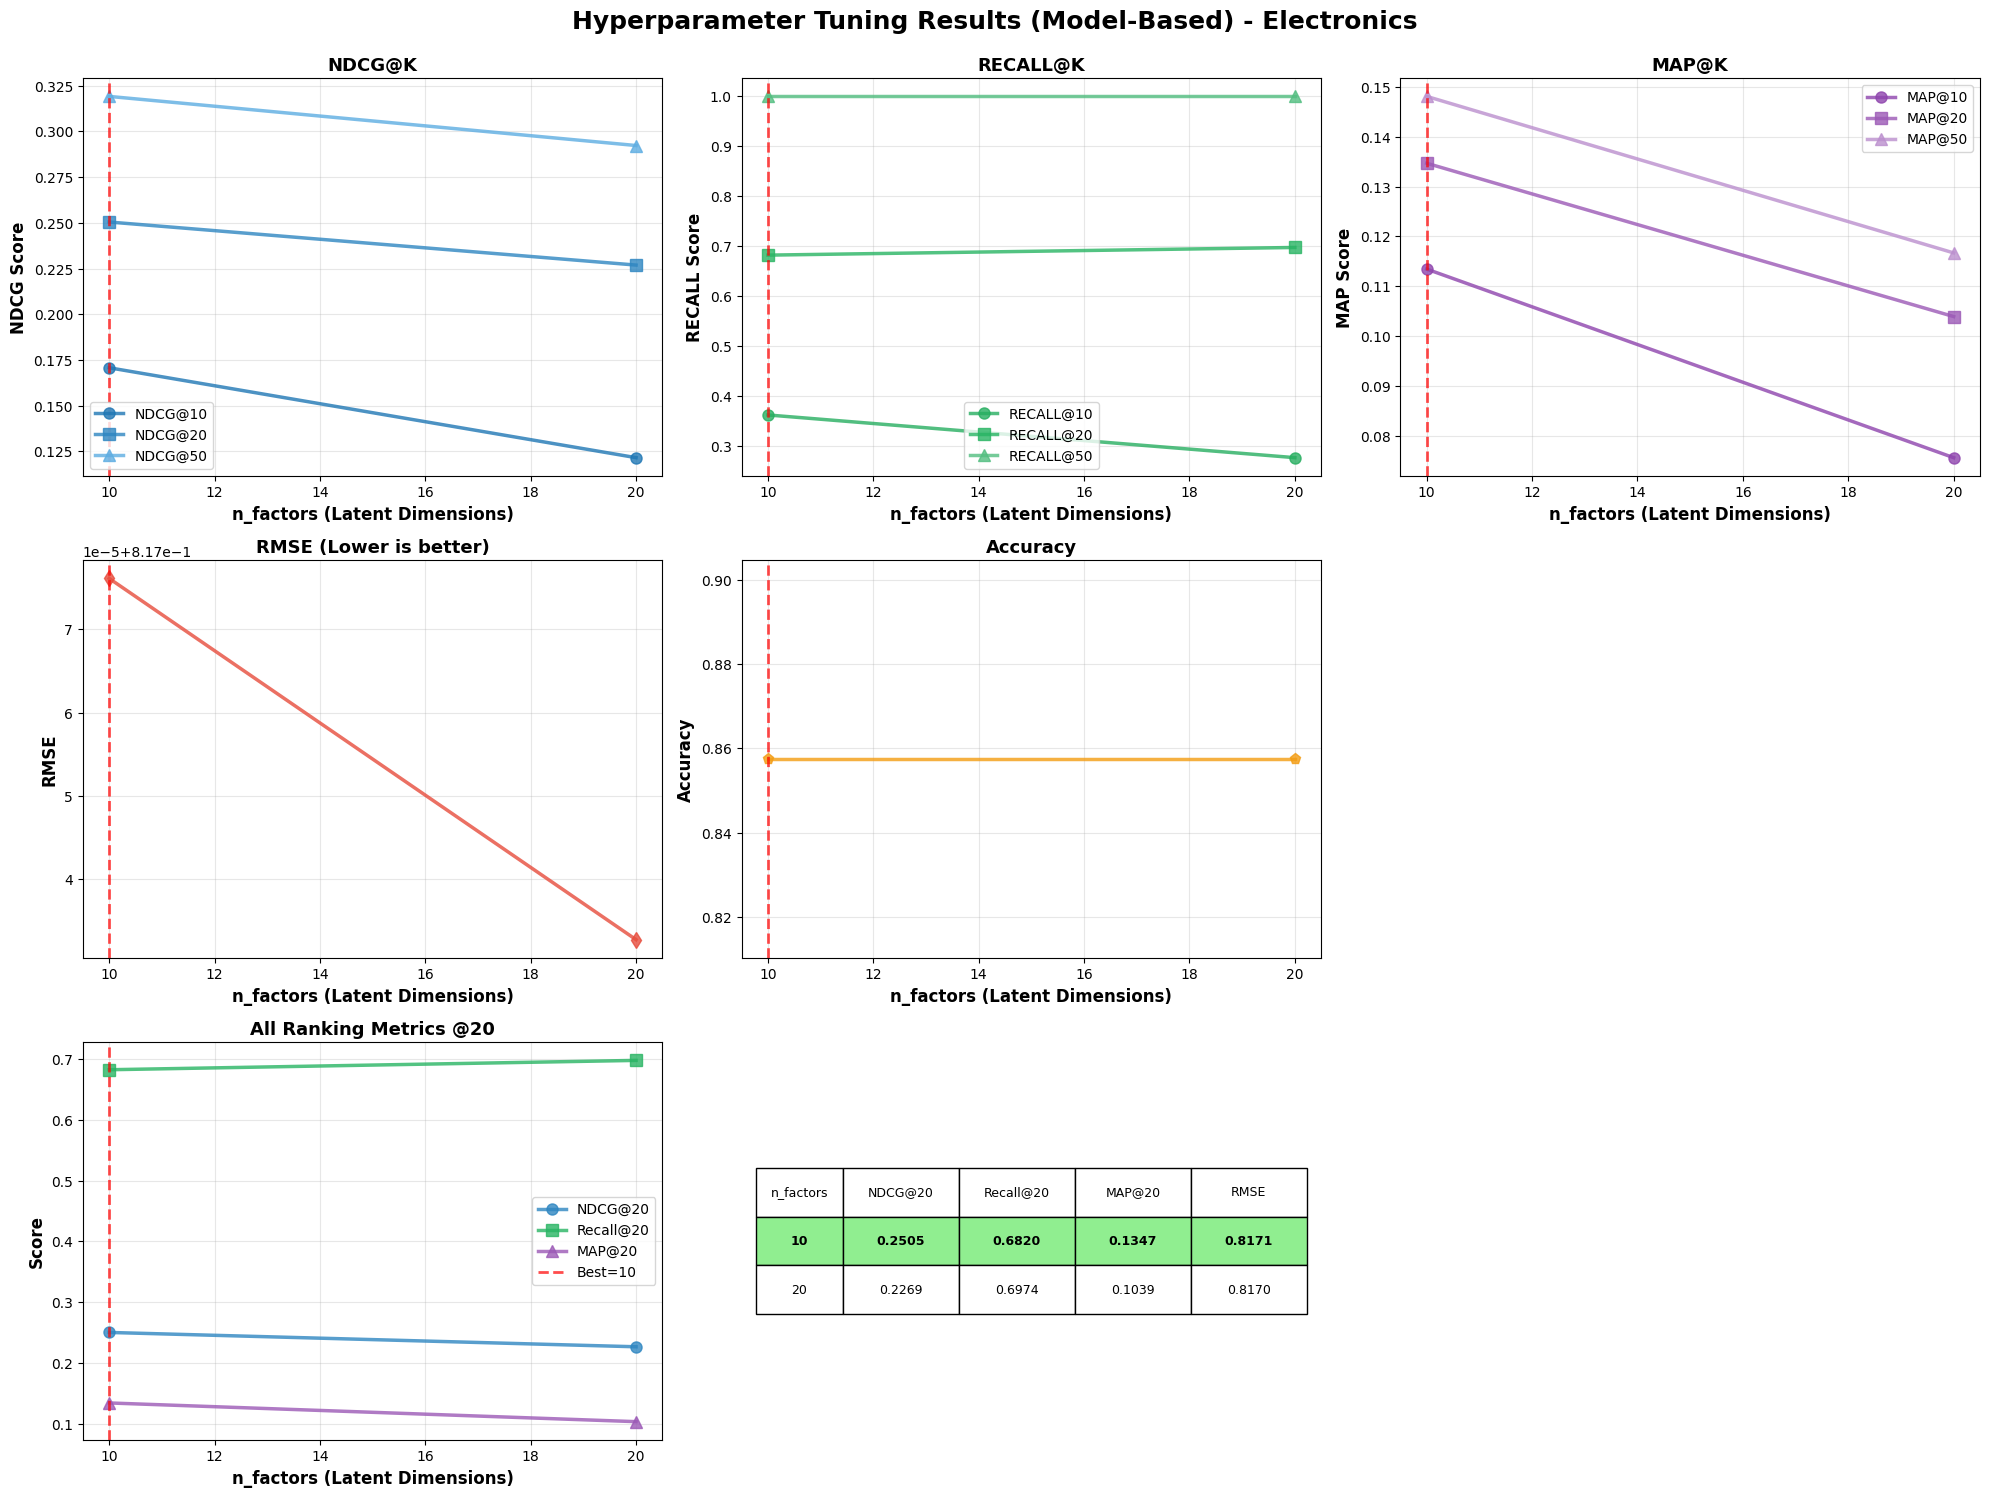

2025-11-03 01:27:41,610 - INFO - SVD: 0.01s | U(32556, 10), V(28, 10) | σ[193.1404,337.9588]
2025-11-03 01:27:41,682 - INFO - 
Beauty_and_Personal_Care
2025-11-03 01:27:41,682 - INFO - [Train] Building matrix and initial model...
2025-11-03 01:27:41,685 - INFO - [TRAIN] shape=(22143, 4) | users=16821 | items=23
2025-11-03 01:27:41,694 - INFO - [Matrix] R(16821, 23) nnz=22143 | global_mean=4.2655
2025-11-03 01:27:41,695 - INFO - [Centered] Mean of centered data=0.0000
2025-11-03 01:27:41,695 - WARNING - n_factors=22 too large for (16821, 23), adjusted to 22
2025-11-03 01:27:41,702 - INFO - SVD: 0.01s | U(16821, 22), V(23, 22) | σ[27.5899,51.6412]
2025-11-03 01:27:41,736 - INFO - [Tune] Starting hyperparameter tuning...
2025-11-03 01:27:41,749 - INFO - SVD: 0.01s | U(16821, 10), V(23, 10) | σ[136.5329,195.5607]
2025-11-03 01:27:41,751 - INFO - [VALID] shape=(336, 4) | users=336 | items=23
2025-11-03 01:27:41,857 - INFO - [Eval] RMSE=0.7621, NDCG@10=0.2143
2025-11-03 01:27:41,864 - INFO -

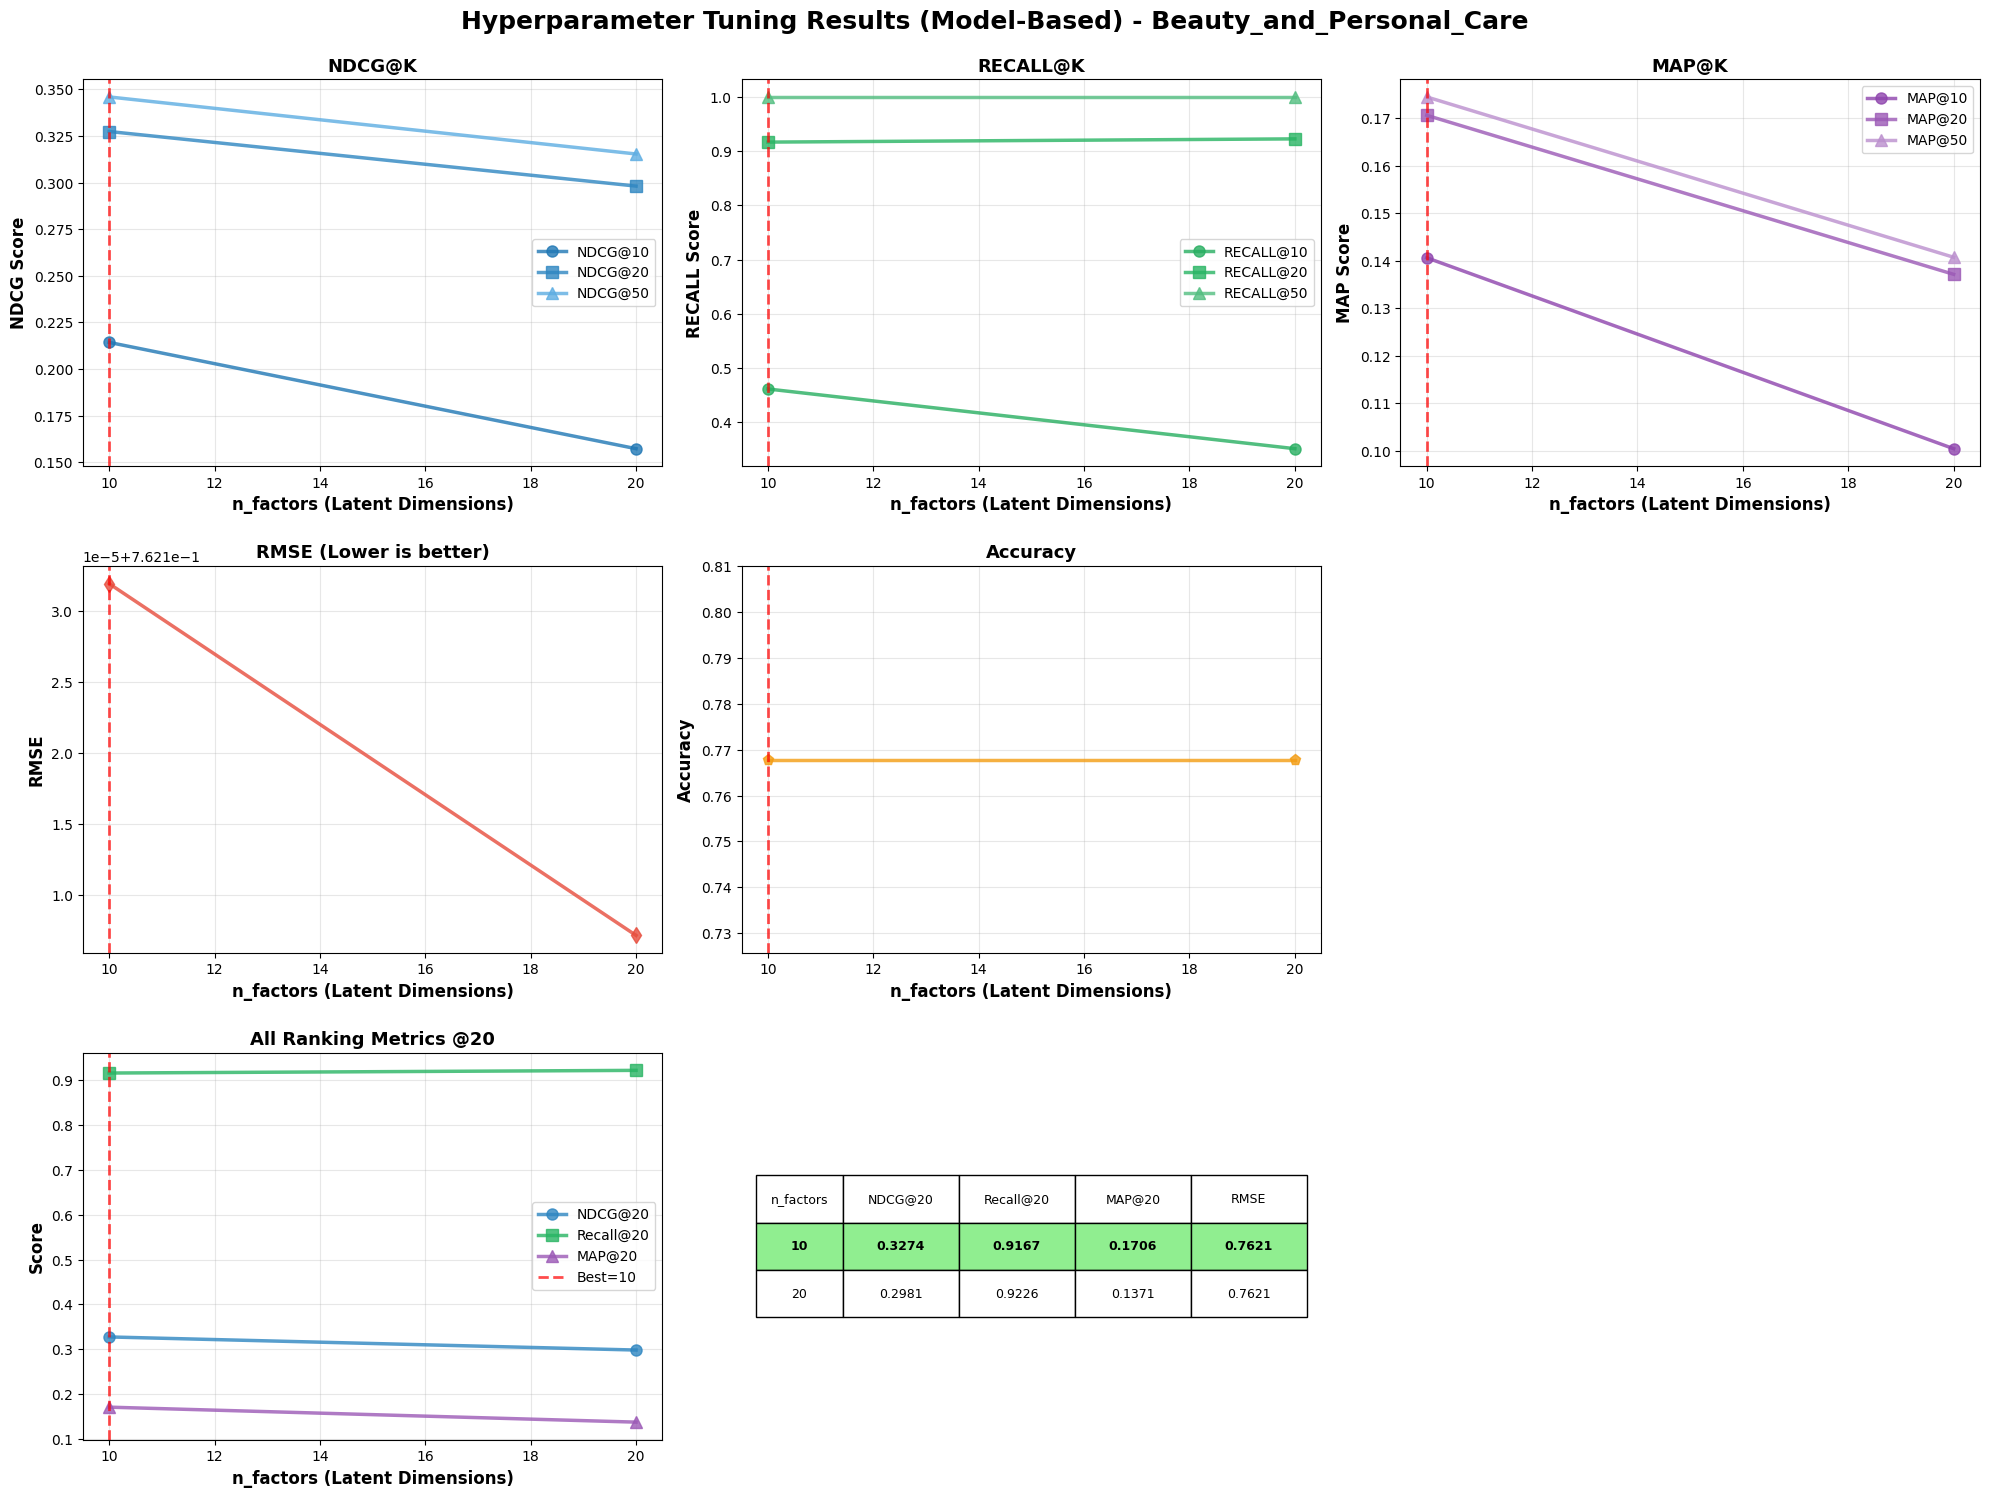

2025-11-03 01:27:42,775 - INFO - SVD: 0.01s | U(16821, 10), V(23, 10) | σ[136.5329,195.5607]
2025-11-03 01:27:42,813 - INFO - 
Sports_and_Outdoors
2025-11-03 01:27:42,814 - INFO - [Train] Building matrix and initial model...
2025-11-03 01:27:42,816 - INFO - [TRAIN] shape=(14534, 4) | users=11776 | items=23
2025-11-03 01:27:42,823 - INFO - [Matrix] R(11776, 23) nnz=14534 | global_mean=4.5219
2025-11-03 01:27:42,823 - INFO - [Centered] Mean of centered data=0.0000
2025-11-03 01:27:42,823 - WARNING - n_factors=22 too large for (11776, 23), adjusted to 22
2025-11-03 01:27:42,829 - INFO - SVD: 0.01s | U(11776, 22), V(23, 22) | σ[15.4992,38.1921]
2025-11-03 01:27:42,852 - INFO - [Tune] Starting hyperparameter tuning...
2025-11-03 01:27:42,861 - INFO - SVD: 0.00s | U(11776, 10), V(23, 10) | σ[111.3284,184.7067]
2025-11-03 01:27:42,862 - INFO - [VALID] shape=(157, 4) | users=157 | items=23
2025-11-03 01:27:43,015 - INFO - [Eval] RMSE=0.8632, NDCG@10=0.2098
2025-11-03 01:27:43,021 - INFO - SVD:

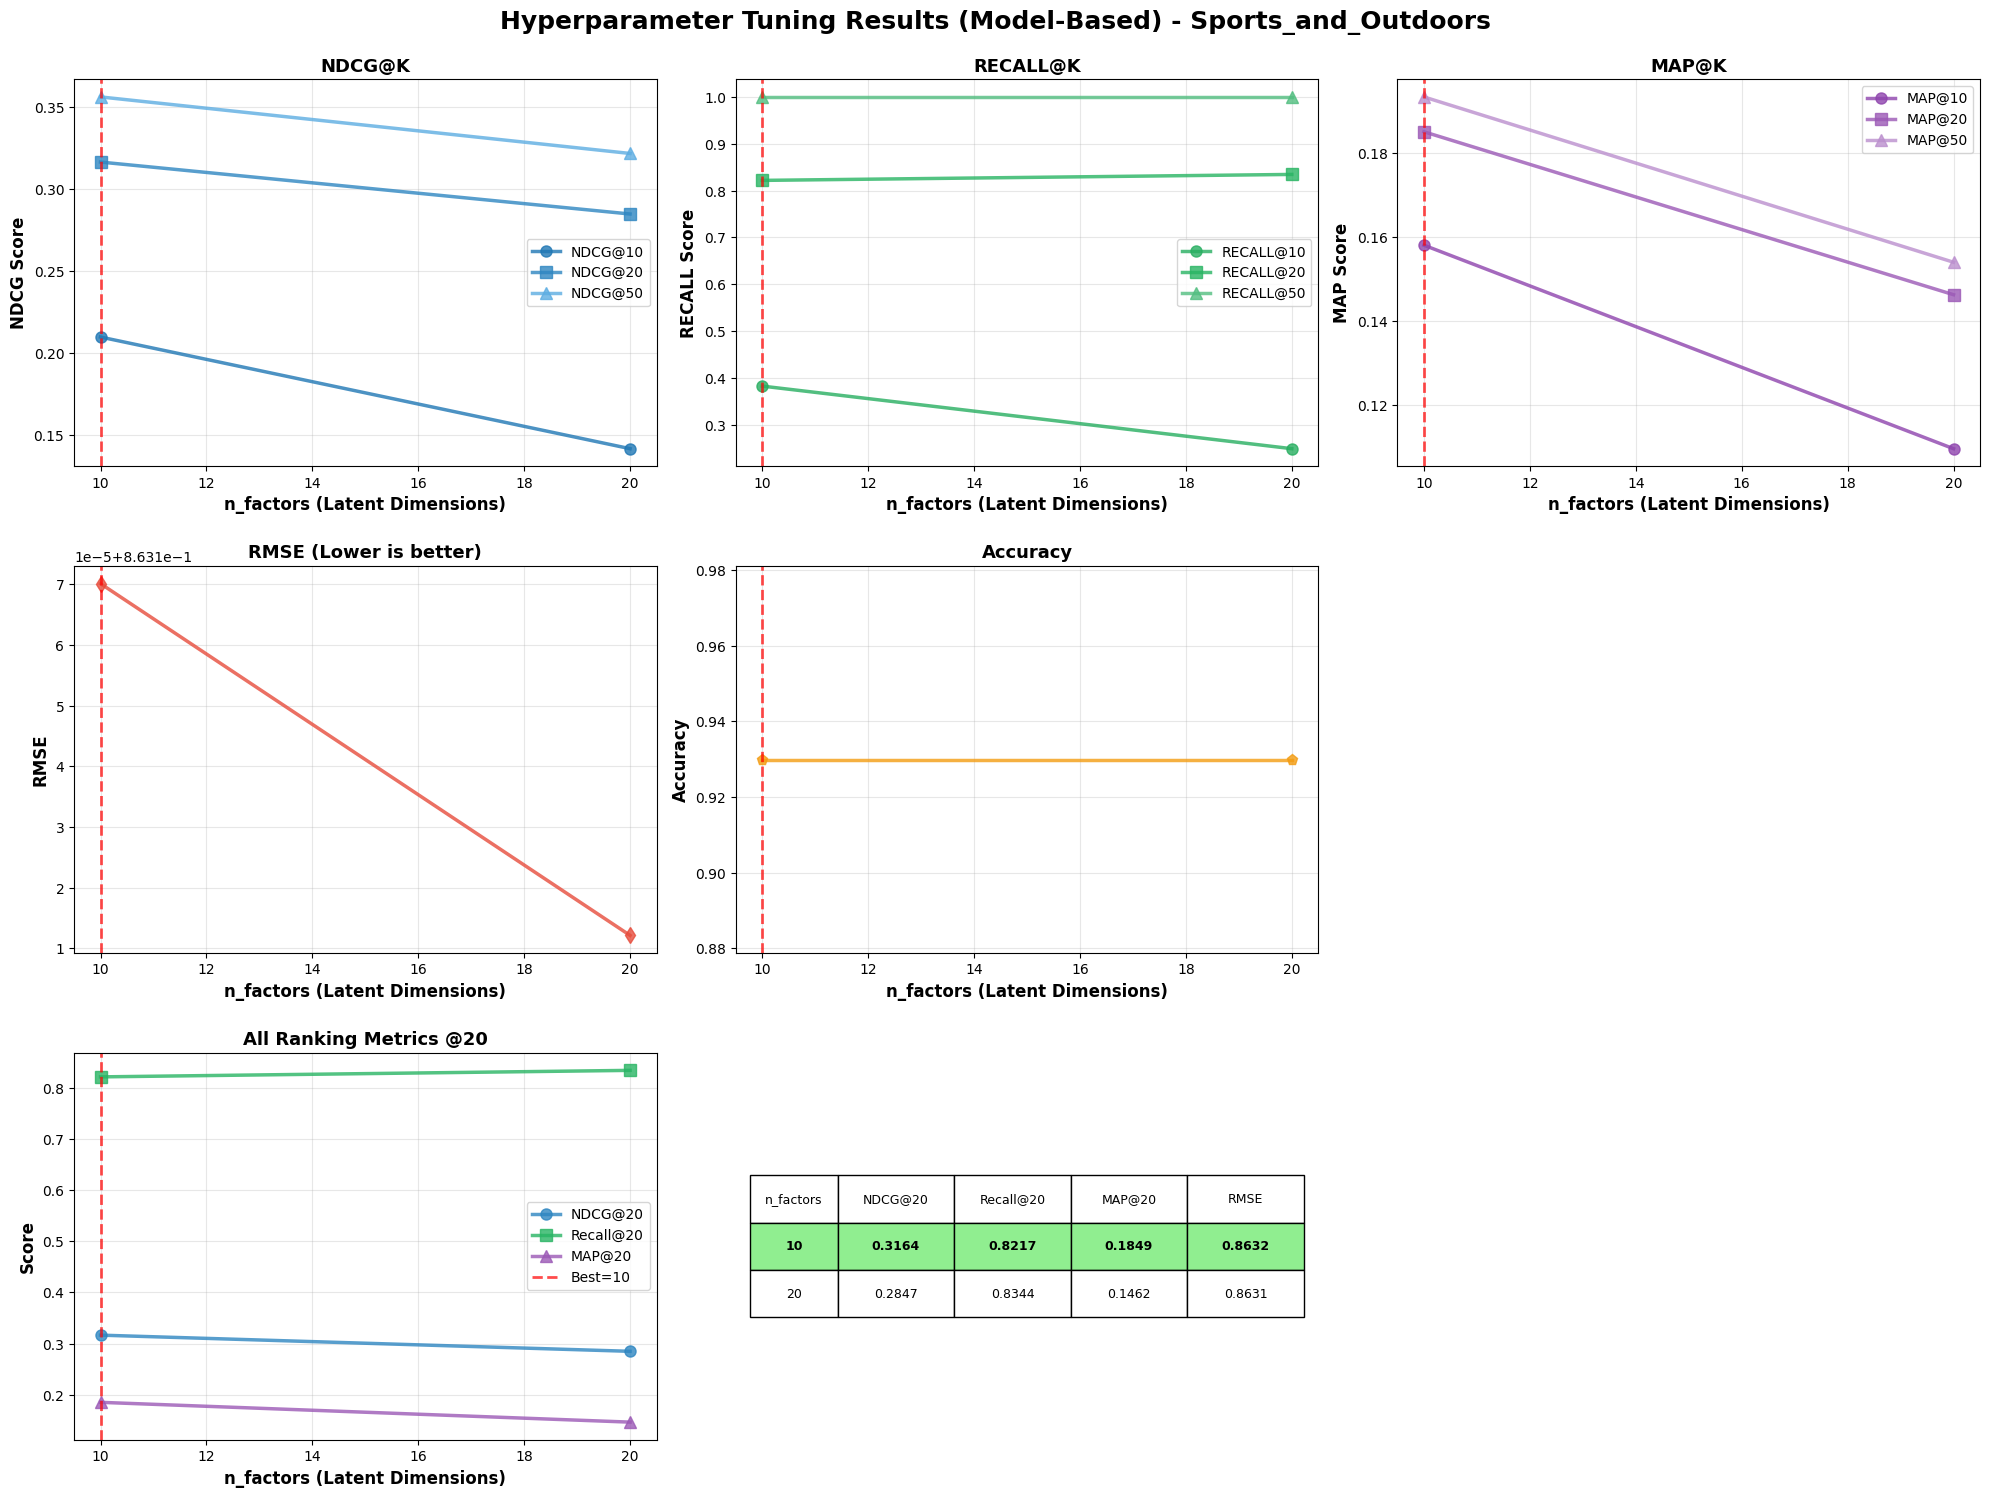

2025-11-03 01:27:43,871 - INFO - SVD: 0.00s | U(11776, 10), V(23, 10) | σ[111.3283,184.7067]
2025-11-03 01:27:43,949 - INFO - 
PHASE 1 COMPLETE
2025-11-03 01:27:43,956 - INFO -   Electronics: n_factors=10 (tuned)
2025-11-03 01:27:43,964 - INFO -   Beauty_and_Personal_Care: n_factors=10 (tuned)
2025-11-03 01:27:43,964 - INFO -   Sports_and_Outdoors: n_factors=10 (tuned)


In [9]:
logger.log_info("PHASE 1: TRAINING + TUNING\n")
workflow_results = {}

for cat in CATEGORY:
    logger.log_info(f"\n{'='*70}\n{cat}\n{'='*70}")
    model_dir = MODELS_DIR / "model" / cat
    workflow_results[cat] = _train_single_category(cat, model_dir, FACTORS_VALUES, Configurations.get_eval_samples_tuning())

logger.log_info("\nPHASE 1 COMPLETE")
for cat in CATEGORY:
    status = 'tuned' if workflow_results[cat]['tuned_now'] else 'cached'
    logger.log_info(f"  {cat}: n_factors={workflow_results[cat]['best_factors']} ({status})")

2025-11-03 01:27:43,982 - INFO - 
PHASE 2: FINAL EVALUATION

2025-11-03 01:27:43,985 - INFO - 
Electronics (n_factors=10)
2025-11-03 01:27:44,011 - INFO - [TEST] shape=(349, 4) | users=349 | items=27
2025-11-03 01:27:44,226 - INFO - [Eval] RMSE=0.8193, NDCG@10=0.1675
2025-11-03 01:27:44,226 - INFO - 
Beauty_and_Personal_Care (n_factors=10)
2025-11-03 01:27:44,236 - INFO - [TEST] shape=(304, 4) | users=304 | items=23
2025-11-03 01:27:44,347 - INFO - [Eval] RMSE=0.7575, NDCG@10=0.2260
2025-11-03 01:27:44,347 - INFO - 
Sports_and_Outdoors (n_factors=10)
2025-11-03 01:27:44,355 - INFO - [TEST] shape=(147, 4) | users=147 | items=22
2025-11-03 01:27:44,408 - INFO - [Eval] RMSE=0.8539, NDCG@10=0.1968


category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Electronics""","""test""",349,0.819348,0.845272,0.372493,0.167517,0.106382,0.727794,0.255382,0.129463,1.0,0.314079,0.140875
"""Beauty_and_Personal_Care""","""test""",304,0.757518,0.756579,0.450658,0.226034,0.159182,0.901316,0.337453,0.188413,1.0,0.359447,0.193019
"""Sports_and_Outdoors""","""test""",147,0.853946,0.884354,0.37415,0.196791,0.142665,0.904762,0.326545,0.175993,1.0,0.347707,0.180396


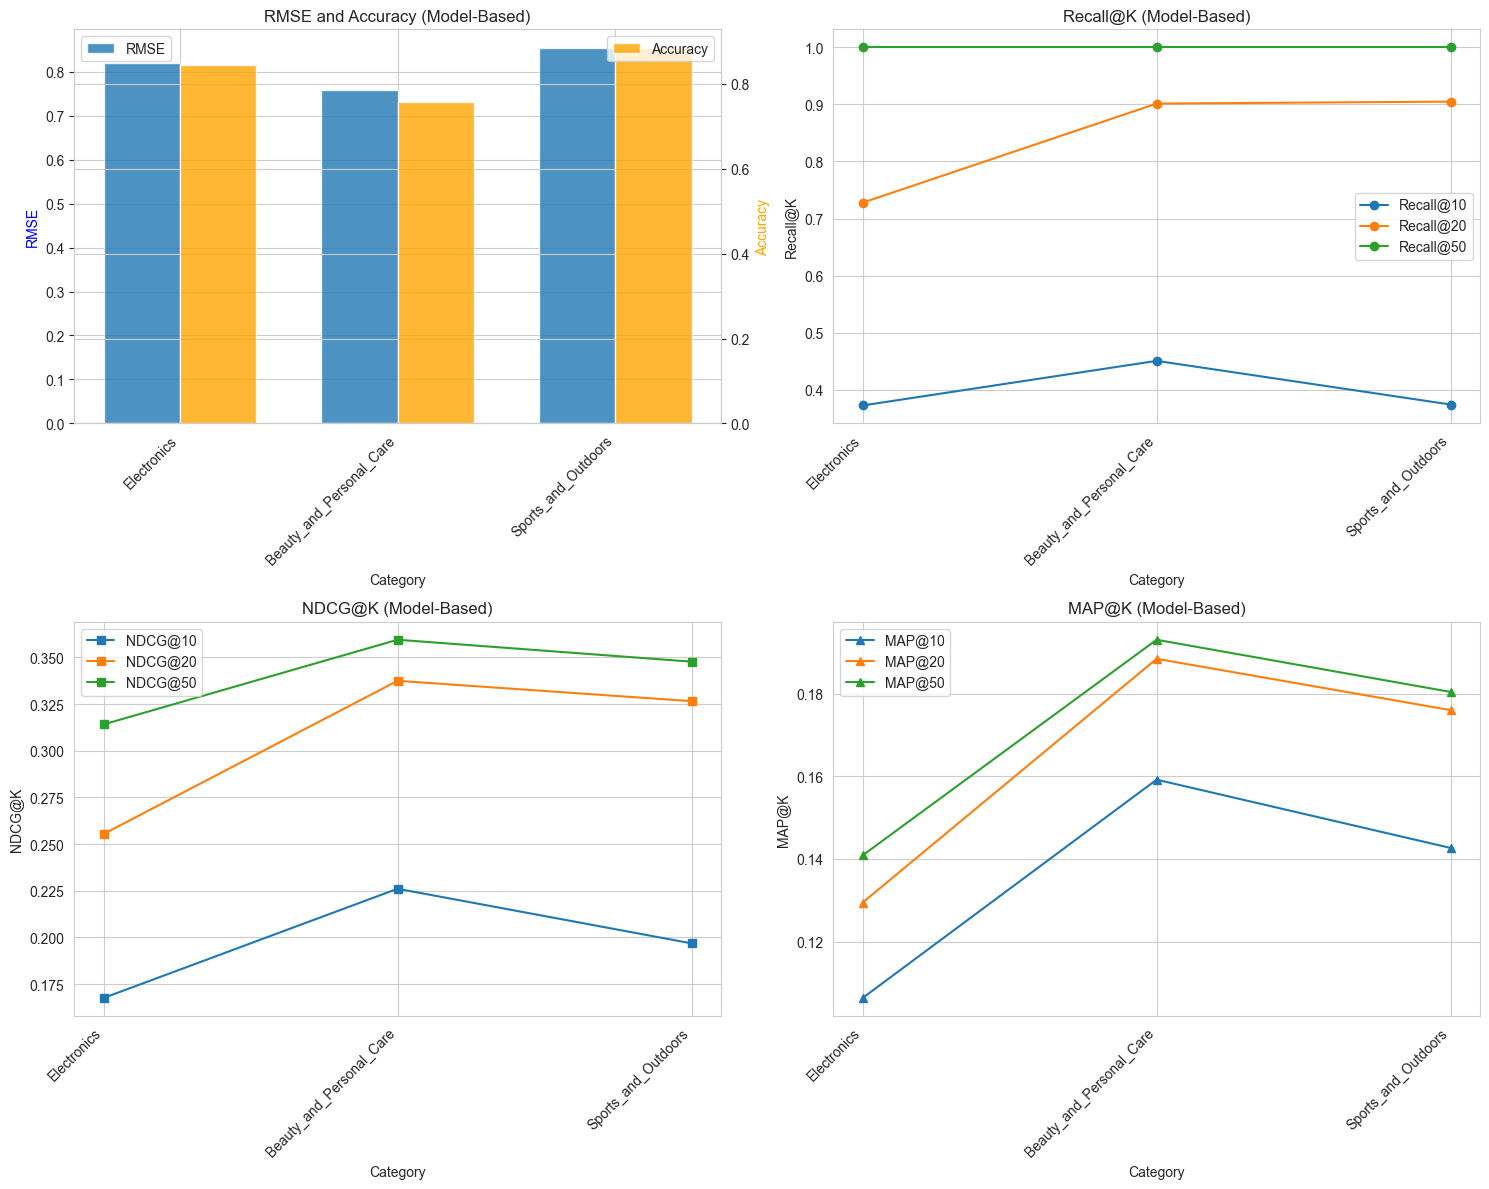

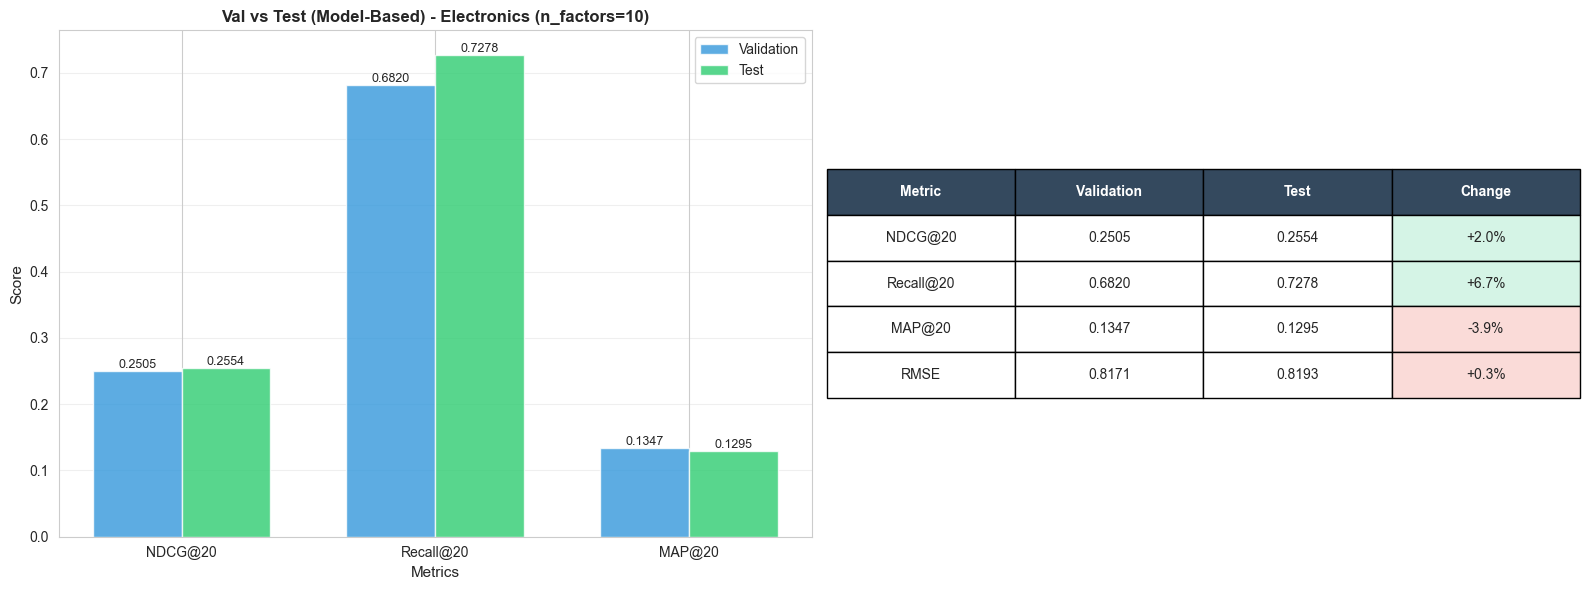

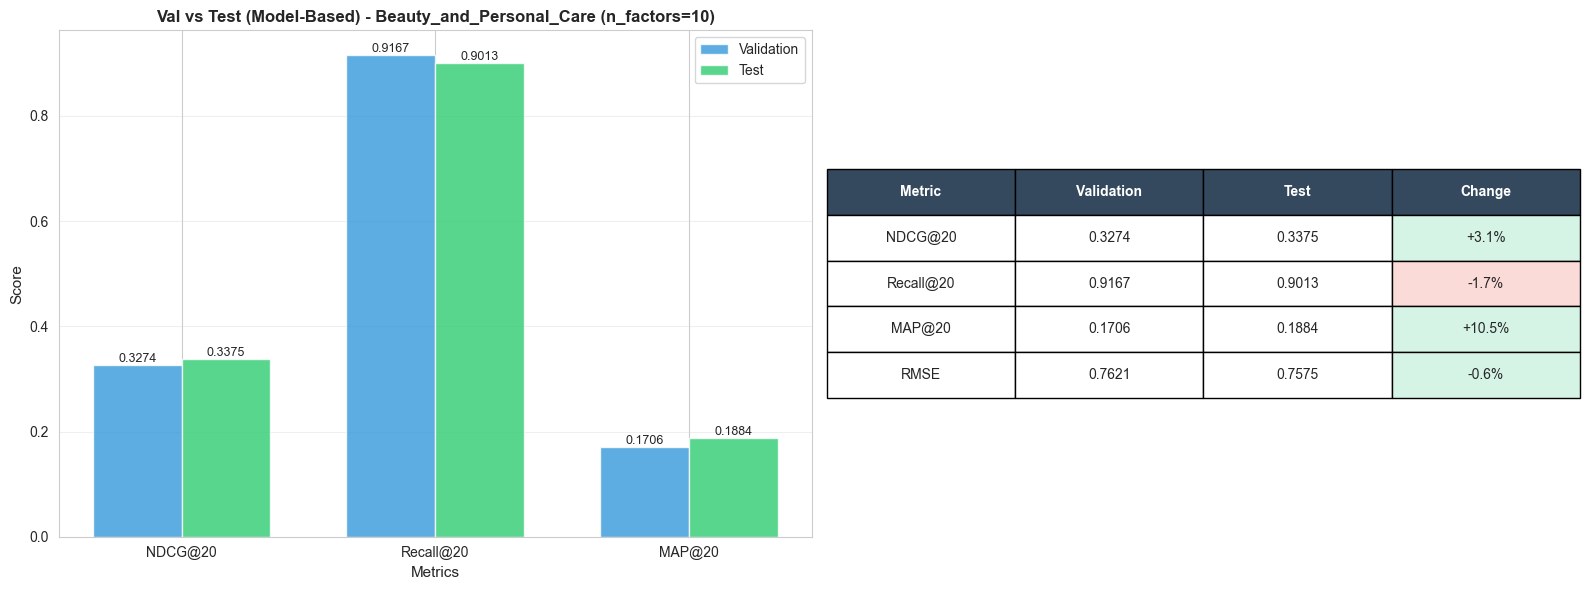

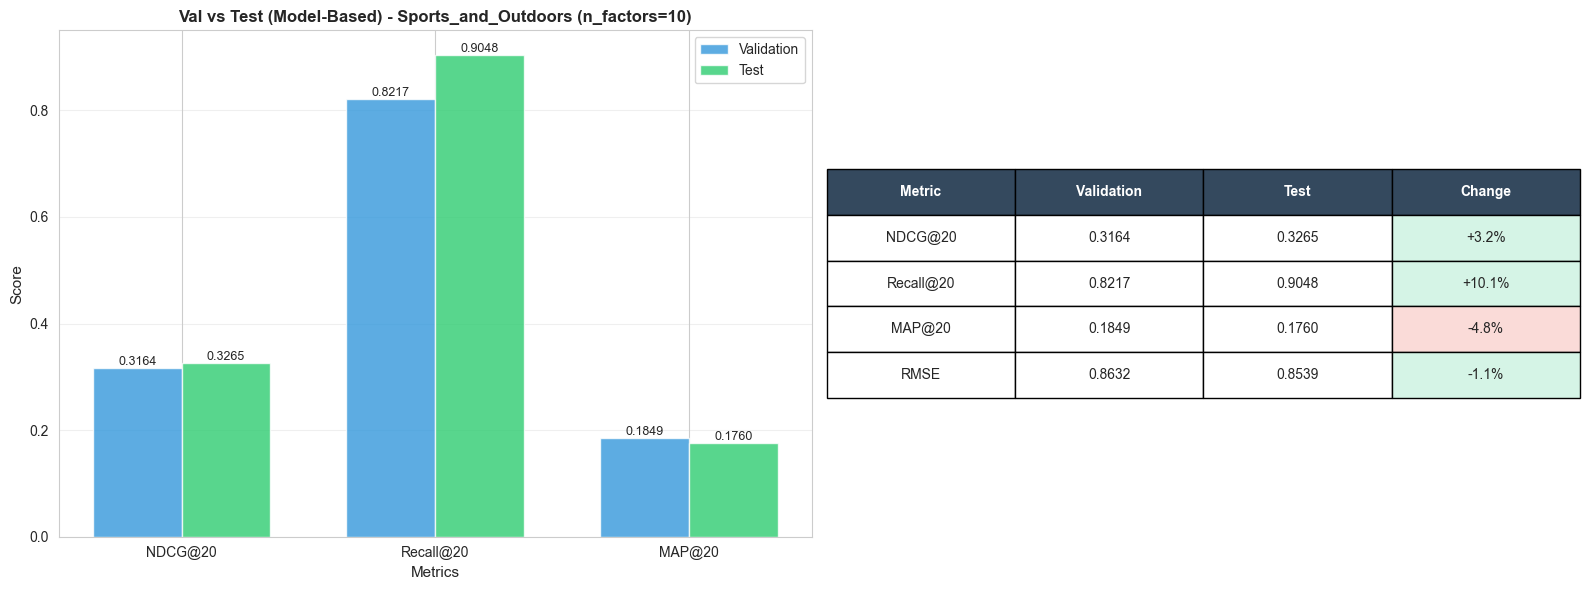

2025-11-03 01:27:45,797 - INFO - 
COMPLETE


In [10]:
logger.log_info("\nPHASE 2: FINAL EVALUATION\n")

if 'workflow_results' not in locals():
    workflow_results = {cat: {'best_factors': Configurations.load_best_factors(cat)} for cat in CATEGORY}

n_eval_final = Configurations.get_eval_samples_final()

for cat in CATEGORY:
    logger.log_info(f"\n{cat} (n_factors={workflow_results[cat]['best_factors']})")
    final_artifacts = load_model_artifacts(MODELS_DIR / "model" / cat)
    results = evaluate_model_based(cat, final_artifacts, k_values=[10, 20, 50], split="test", sample_users=n_eval_final)
    
    if results:
        workflow_results[cat]['test_results'] = results

test_results = [workflow_results[cat]['test_results'] for cat in CATEGORY if 'test_results' in workflow_results[cat]]
if test_results:
    df_final = pl.DataFrame(test_results)
    display(df_final)
    df_final.write_csv(MODELS_DIR / 'model' / 'final_test_results.csv')
    visualize_final_results(test_results, save_dir=MODELS_DIR / 'model', algo_name='Model-Based', k_values=[10, 20, 50])

for cat in CATEGORY:
    tuning_csv = MODELS_DIR / 'model' / f'tuning_{cat}.csv'
    if tuning_csv.exists() and 'test_results' in workflow_results[cat]:
        df_tuning = pl.read_csv(tuning_csv)
        best_factors = workflow_results[cat]['best_factors']
        tuning_row = df_tuning.filter(pl.col('n_factors') == best_factors).row(0, named=True)
        final_row = df_final.filter(pl.col('category') == cat).row(0, named=True)
        visualize_val_test_comparison(cat=cat, param_val=best_factors, tuning_row=tuning_row,
            final_row=final_row, save_dir=MODELS_DIR / 'model', param_name='n_factors', algo_name='Model-Based')

logger.log_info("\nCOMPLETE")

In [11]:
def recommend_model_ui(user_id: str, n_recs: int = 5, models_dir: str | Path | None = None, category: str | None = None):
    cat = category or CATEGORY[0]
    model_dir = Path(models_dir) if models_dir else (MODELS_DIR / "model" / cat)
    artifacts = load_model_artifacts(model_dir)
    return recommend_model_based(user_id, n_recs, artifacts)

def test_all_categories():
    for cat in CATEGORY:
        try:
            model_dir = MODELS_DIR / "model" / cat
            if not model_dir.exists():
                continue
            artifacts = load_model_artifacts(model_dir)
            user_rev = artifacts['user_rev']
            if len(user_rev) > 0:
                recs = recommend_model_ui(user_rev[0], n_recs=N_RECS, category=cat)
                display(recs)
        except Exception as e:
            logger.log_exception(f"{cat}: {e}")

In [12]:
test_all_categories()

parent_asin,score
str,f64
"""B07GZFM1ZM""",4.500688
"""B01K8B8YA8""",4.499587
"""B00JO6RO8C""",4.499069
"""B083TH1B45""",4.499037
"""B071R715MZ""",4.499024
"""B0BN74ZJDK""",4.498943
"""B07H65KP63""",4.49888
"""B08KG14KCT""",4.498869
"""B0BS2ZMHCL""",4.498798


parent_asin,score
str,f64
"""B00HFG0FAM""",4.266344
"""B0BJLPRXZ6""",4.266307
"""B0C47F7BPT""",4.266198
"""B01LSUQSB0""",4.266105
"""B0CBNPG2FS""",4.265794
"""B09KM16YYV""",4.26558
"""B09GWLJPTH""",4.265511
"""B01BD8EL0W""",4.265478
"""B07NSCDGX7""",4.265435


parent_asin,score
str,f64
"""B00NPLSZF8""",4.525992
"""B0BWQ74LCL""",4.523709
"""B0C8BS352W""",4.523403
"""B00NWXLQD2""",4.523361
"""B0BYCBLSPT""",4.52222
"""B0BX2WK4V4""",4.52214
"""B001ID4ZY0""",4.522109
"""B0C4MNRN7R""",4.521883
"""B00C6OUDX2""",4.521614
